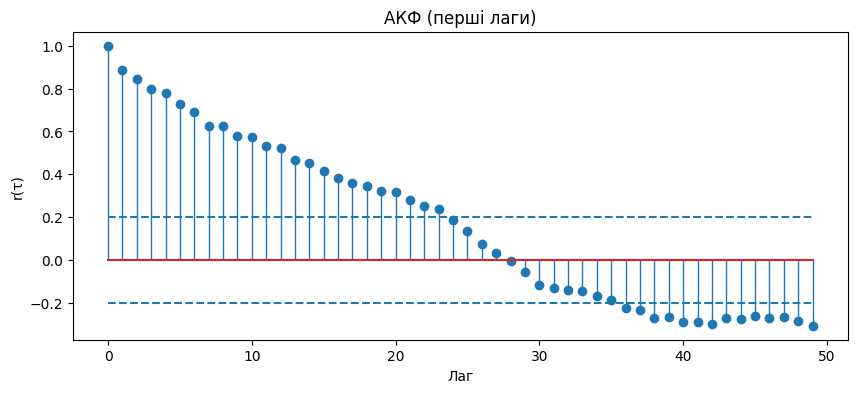

Значущих АКФ: 38


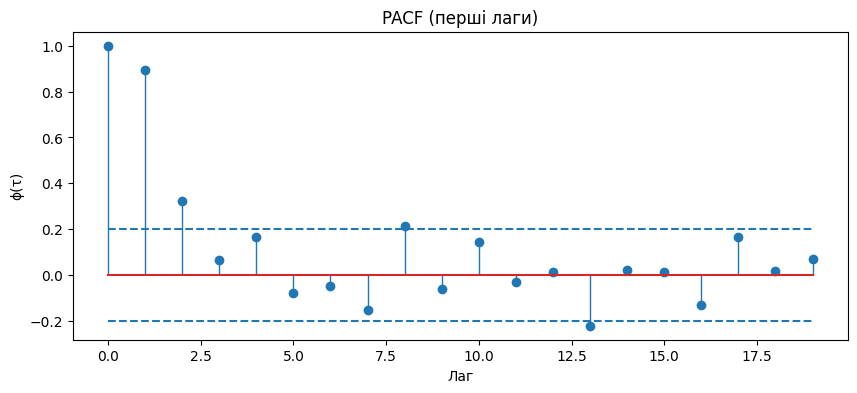

Значущих PACF: 5
ρ̂: [0.60535511 0.32263684], σ̂²=1.25075
t-тест ρ̂1: t=5.331, p-value=0.000
t-тест ρ̂2: t=2.841, p-value=0.005


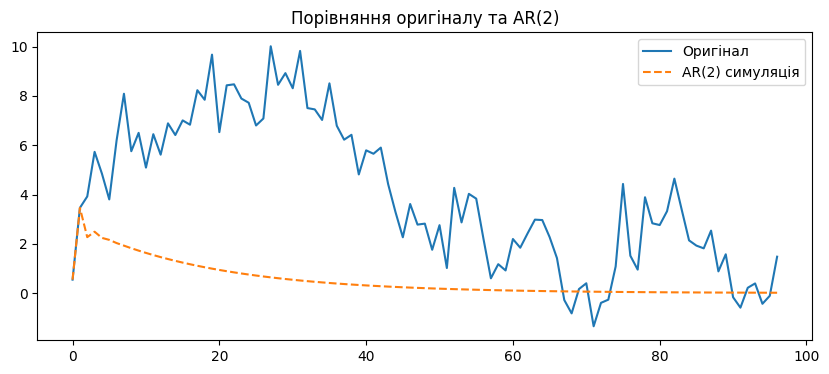

Прогноз: [1.1391  1.40895 1.47633]
Фактичні: [0.24067 0.60415 2.17862]
Похибки: [-0.89843 -0.80479  0.70229]


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, yule_walker
from statsmodels.tsa.ar_model import AutoReg
from scipy import stats

# === Параметри ===
PATH       = r"C:/Users/slavi/Downloads/ts.csv"
TARGET_LEN = 100   # бажана довжина ряду після розширення
N_TEST     = 3     # кількість точок для перевірки прогнозу
ALPHA      = 0.05  # рівень значущості

# === 1. Зчитуємо існуючий ряд (по одному числу на рядок) ===
df0 = pd.read_csv(PATH, header=None, names=['y'])
y0 = df0['y'].astype(float).values        # зараз довжина ≈50

# === 2. Якщо потрібно — розширюємо ряд до TARGET_LEN ===
if len(y0) < TARGET_LEN:
    rho, sigma = yule_walker(y0, order=2)
    y_ext = np.empty(TARGET_LEN)
    y_ext[:len(y0)] = y0
    for t in range(len(y0), TARGET_LEN):
        eps = np.random.normal(0, np.sqrt(sigma))
        y_ext[t] = rho[0]*y_ext[t-1] + rho[1]*y_ext[t-2] + eps
    # Перезаписуємо файл новим рядом
    pd.DataFrame(y_ext, columns=['y']).to_csv(PATH, index=False, header=False)
    print(f"Файл '{PATH}' розширено до {TARGET_LEN} значень.")
    y_full = y_ext
else:
    y_full = y0.copy()

# === 3. Розбиваємо на тренувальну та тестову частини ===
N_TOTAL = len(y_full)
N_MODEL = N_TOTAL - N_TEST
y_train = y_full[:N_MODEL]
y_test  = y_full[N_MODEL:]

# Обчислюємо поріг довіри ±z_{1-α/2}/√N
z = stats.norm.ppf(1 - ALPHA/2)
conf_level = z / np.sqrt(N_MODEL)

# === Завдання 1: АКФ ===
nlags_acf = min(49, N_MODEL-1)
acf_vals = acf(y_train, nlags=nlags_acf, fft=False)

plt.figure(figsize=(10,4))
marker, stems, base = plt.stem(range(nlags_acf+1), acf_vals)
plt.setp(stems, 'linewidth', 1)
plt.hlines([ conf_level, -conf_level ], 0, nlags_acf, linestyles='--')
plt.title('АКФ (перші лаги)')
plt.xlabel('Лаг')
plt.ylabel('r(τ)')
plt.show()

print("Значущих АКФ:", np.sum(np.abs(acf_vals) > conf_level))

# === Завдання 2: PACF ===
nlags_pacf   = min(19, N_MODEL-1)
pacf_output  = pacf(y_train, nlags=nlags_pacf)
pacf_vals    = pacf_output[0] if isinstance(pacf_output, tuple) else pacf_output

plt.figure(figsize=(10,4))
marker, stems, base = plt.stem(range(nlags_pacf+1), pacf_vals)
plt.setp(stems, 'linewidth', 1)
plt.hlines([ conf_level, -conf_level ], 0, nlags_pacf, linestyles='--')
plt.title('PACF (перші лаги)')
plt.xlabel('Лаг')
plt.ylabel('ϕ(τ)')
plt.show()

print("Значущих PACF:", np.sum(np.abs(pacf_vals) > conf_level))

# === Завдання 3: Ідентифікація AR(2) ===
order = 2
rho, sigma = yule_walker(y_train, order=order)
print(f"ρ̂: {rho}, σ̂²={sigma:.5f}")

se       = np.sqrt(sigma / N_MODEL)
t_stats  = rho / se
p_vals   = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=N_MODEL-order))
for i, (t, p) in enumerate(zip(t_stats, p_vals), start=1):
    print(f"t-тест ρ̂{i}: t={t:.3f}, p-value={p:.3f}")

# === Імітація AR(2) ===
y_sim = np.zeros(N_MODEL)
y_sim[:order] = y_train[:order]
for t in range(order, N_MODEL):
    y_sim[t] = rho[0]*y_sim[t-1] + rho[1]*y_sim[t-2]

plt.figure(figsize=(10,4))
plt.plot(y_train, label='Оригінал')
plt.plot(y_sim, '--', label='AR(2) симуляція')
plt.title('Порівняння оригіналу та AR(2)')
plt.legend()
plt.show()

# === Прогноз 1–3 кроки вперед ===
model    = AutoReg(y_train, lags=order, old_names=False).fit()
forecast = model.predict(start=N_MODEL, end=N_MODEL+N_TEST-1)

print("Прогноз:", np.round(forecast,5))
print("Фактичні:", np.round(y_test,5))
print("Похибки:", np.round(y_test - forecast,5))
